In [1]:
# essentials
import numpy as np
import tensorflow as tf
from tensorflow import keras
from utils.hparams import hparams as hp 
import utils.audio as audio

from models import decoder, encoder, gan

# misc
import os
import ntpath
import matplotlib.pyplot as plt
import random
from datetime import datetime
import io


2024-05-22 15:20:35.753411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 15:20:35.753444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 15:20:35.754671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 15:20:35.761499: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 15:20:36.406282: W tensorflow/compiler/tf2

# Constants

In [2]:
from dotenv import load_dotenv

load_dotenv() # allow using system specific data

CURRENT_EPOCH = 0 # This is to combat kernel crashing 
EPOCHS = 20000
BATCH_SIZE = 100
TEST_BATCH_SIZE = 10
BATCH_DATA_PATH = os.environ.get("BATCH_DATA_PATH")
GENERATED_IMAGES_PATH = os.environ.get("GENERATED_IMAGES_PATH")
SAVED_MODELS_PATH = os.environ.get("SAVED_MODELS_PATH")
DATASET_PATH = os.environ.get("DATASET_PATH")
TEST_DATASET_PATH = os.environ.get("TEST_DATASET_PATH")

# Image and audio settings, must be verified beforehands
IMAGE_SHAPE = (64, 64, 3)
AUDIO_SPECTROGRAM_SHAPE = (4, 601, 1)
MASKED_IMAGE_SHAPE = (32, 64, 3)
# most videos are 10 seconds, so this number line up with the expected frame rate
AVERAGE_FRAME_PER_VIDEO = 217 # number of frames / number of audio files

MODEL_NAME = os.environ.get("MODEL_NAME")

# Load Batch Data
### Pre-determined randomized batches to avoid wasting time randomizing it on the fly.
`BATCH_DATA` is structured as a 3D array (dictionary here but the key is the index so same thing) of size `EPOCHS*BATCH_SIZE*2`.\
Every epoch, `BATCH_DATA` is called to fetch a certain epoch, which returns the array of size `BATCH_SIZE*2`.\
The 2 names corresponds to the name of the image, as well as the reference, where the image is the one we mask and generate based on, while the reference is the reference image of the same face

# Model Input Pipeline

Utilities

In [3]:
def original_image_path_gen(folder_path):
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):
            yield file_path

In [4]:
def ref_image_path_gen(folder_path):
    """
    Generates reference frame path for each frame in the folder.
    NOTE: this might not work as intended if there are more than 1 person in the video.
    Assumes os.listdir returns the files in the same order (should be the case in most systems).
    Returns: tuple
        path: the path to the reference image
        modify: whether to modify the image (if a reference cannot be found)
    """
    # not a fan of the loop, but it is what it is
    for file in os.listdir(folder_path):
        path = os.path.join(folder_path, file)
        if os.path.isfile(path):
            counter = 0
            video_name, frame_index = file.split("_") # the frame file is <source_video>_<frame_index>
            frame_index = int(frame_index.split(".")[0]) # remove the file extension
            ref_frame_path = path
            ref_frame_index = frame_index
            # find a valid reference frame of the same person. Assumes each video is of a single person.
            while ref_frame_index == frame_index or not os.path.exists(ref_frame_path):
                ref_frame_index = random.randint(0, AVERAGE_FRAME_PER_VIDEO - 1)
                ref_frame_path = os.path.join(folder_path, video_name + "_" + str(ref_frame_index) + ".png")
                counter+=1 # stop once counter reaches 10
                if counter >= 10:
                    yield path, True # return the same image, but we'll flip it
            yield ref_frame_path, False

In [5]:
def crop_audio_window(spectrogram, start_frame_num):
    """
    Get the audio spectrogram window corresponding to the frame.
    """
    # I did some testing, there are 8 samples per second
    start_idx = int(8 * (start_frame_num // hp.fps))
    
    end_idx = start_idx + 4 # half a second to provide some padding
    if (spectrogram.shape[0] < end_idx):
        return spectrogram[-4:, :]

    return spectrogram[start_idx : end_idx, :]

In [6]:
def load_audio_data(image_path, dataset_path):
    """
    Load the audio data from the file.
    """
    image_path = image_path.numpy().decode("utf-8")
    dataset_path = dataset_path.numpy().decode("utf-8")
    frame_name = ntpath.basename(image_path) # get the name without the path (should also work on windows)
    video_name, frame_index = frame_name.split("_") # the frame file is <source_video>_<frame_index>
    frame_index = int(frame_index.split(".")[0]) # remove the file extension

    audio_path = os.path.join(dataset_path, "audio", video_name + ".wav")

    wav = audio.load_wav(audio_path, hp.sample_rate)
    # get the spectrogram, seems inefficient to do this every time
    spectrogram = audio.melspectrogram(wav)
    spectrogram_window = crop_audio_window(spectrogram, frame_index)
    spectrogram_window = tf.expand_dims(spectrogram_window, axis=-1) # add channel dimension
    spectrogram_window = tf.convert_to_tensor(spectrogram_window)
    return spectrogram_window

In [7]:
def load_image(image_path, modify):
    """
    Load the image from the file.
    Args:
        image_path: the path to the image to load
        modify: whether to modify this image TODO
    """
    image_path = image_path.numpy().decode("utf-8")
        
    raw = tf.io.read_file(image_path)
    image = tf.image.decode_png(raw, channels=3)

    image = tf.cast(image, tf.float32) / 255. # [0 - 1] range

    if modify:
        # add any transformations here
        image = tf.image.flip_left_right(image)

    return image

In [8]:
def load_masked_image(original_image):
    # crop out bottom half
    masked_image = original_image[:32, :, :] # strange bug where the height is a [3] tensor
    return masked_image

Creating the Dataset

In [9]:
def batcher_from_directory(batch_size:int, dataset_path:str, shuffle=False,seed=None) -> tf.data.Dataset:
    """
    Return a tensorflow Dataset object that returns images and spectrograms as required.
    Partly inspired by https://github.com/keras-team/keras/blob/v3.3.3/keras/src/utils/image_dataset_utils.py
    
    Args:
        batch_size: The batch size.
        dataset_path: The path to the dataset folder which must contain the image folder and audio folder.
        shuffle: Whether to shuffle the dataset. Default to False.
        seed: The seed for the shuffle. Default to None.
    """
    image_dataset_path = os.path.join(dataset_path, "image")
    # create the foundation datasets
    og_dataset = tf.data.Dataset.from_generator(lambda: original_image_path_gen(image_dataset_path), 
                                                output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    og_dataset = og_dataset.repeat(None) # repeat indefinitely
    ref_dataset = tf.data.Dataset.from_generator(lambda: ref_image_path_gen(image_dataset_path),
                                                 output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), 
                                                                   tf.TensorSpec(shape=(), dtype=tf.bool)))
    ref_dataset = ref_dataset.repeat(None) # repeat indefinitely

    # create the input datasets
    og_image_dataset = og_dataset.map(lambda x: tf.py_function(load_image, [x, tf.convert_to_tensor(False, dtype=tf.bool)], tf.float32), 
                                        num_parallel_calls=tf.data.AUTOTUNE)
    masked_image_dataset = og_image_dataset.map(lambda x: tf.py_function(load_masked_image, [x], tf.float32),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    ref_image_dataset = ref_dataset.map(lambda x, y: tf.py_function(load_image, [x, y], tf.float32), 
                                        num_parallel_calls=tf.data.AUTOTUNE)
    audio_spec_dataset = og_dataset.map(lambda x: tf.py_function(load_audio_data, [x, dataset_path], tf.float64),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    unsync_spec_dataset = ref_dataset.map(lambda x, _: tf.py_function(load_audio_data, [x, dataset_path], tf.float64),
                                        num_parallel_calls=tf.data.AUTOTUNE)
    
    # ensure shape as tensorflow does not accept unknown shapes
    og_image_dataset = og_image_dataset.map(lambda x: tf.ensure_shape(x, IMAGE_SHAPE))
    masked_image_dataset = masked_image_dataset.map(lambda x: tf.ensure_shape(x, MASKED_IMAGE_SHAPE))
    ref_image_dataset = ref_image_dataset.map(lambda x: tf.ensure_shape(x, IMAGE_SHAPE))
    audio_spec_dataset = audio_spec_dataset.map(lambda x: tf.ensure_shape(x, AUDIO_SPECTROGRAM_SHAPE))
    unsync_spec_dataset = unsync_spec_dataset.map(lambda x: tf.ensure_shape(x, AUDIO_SPECTROGRAM_SHAPE))
    
    # multi input using https://discuss.tensorflow.org/t/train-a-model-on-multiple-input-dataset/17829/4
    full_dataset = tf.data.Dataset.zip((masked_image_dataset, ref_image_dataset, audio_spec_dataset, unsync_spec_dataset), og_image_dataset)
    # if shuffle:
    #     full_dataset = full_dataset.shuffle(buffer_size=batch_size * 8, seed=seed) # not sure why buffer size is such
    
    # batch
    full_dataset = full_dataset.batch(batch_size=batch_size)
    
    return full_dataset

# Dataset
Batch generator technically

In [10]:
x_train = batcher_from_directory(hp.batch_size, DATASET_PATH)
x_test = batcher_from_directory(TEST_BATCH_SIZE, TEST_DATASET_PATH)
x_test.element_spec

((TensorSpec(shape=(None, 32, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 4, 601, 1), dtype=tf.float64, name=None),
  TensorSpec(shape=(None, 4, 601, 1), dtype=tf.float64, name=None)),
 TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None))

In [11]:
# test the batcher
x_test_iter = iter(x_test)

Shape of original image:  (64, 64, 3)
Shape of masked image:  (32, 64, 3)
Shape of spectrogram window:  (4, 601, 1)


(-0.5, 63.5, 63.5, -0.5)

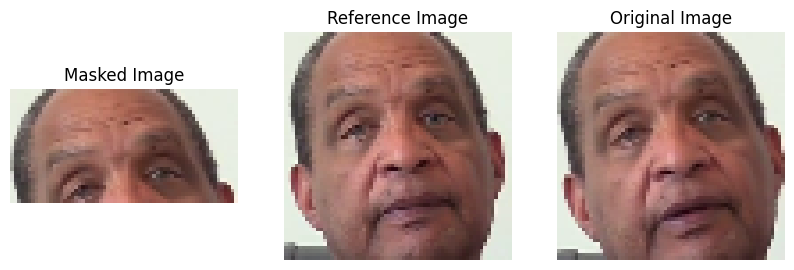

In [12]:
x, original_image = next(x_test_iter)
masked_image, ref_image, spectrogram_window, _ = x

print("Shape of original image: ", original_image[0].shape)
print("Shape of masked image: ", masked_image[0].shape)
print("Shape of spectrogram window: ", spectrogram_window[0].shape)

# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(masked_image[0])
plt.title("Masked Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(ref_image[0])
plt.title("Reference Image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(original_image[0])
plt.title("Original Image")
plt.axis("off")

# Model Definition

In [13]:
masked_id_encoder = encoder.masked_id_encoder
identity_encoder = encoder.identity_encoder
audio_encoder = encoder.audio_encoder
image_decoder = decoder.image_decoder

identity_encoder_disc = encoder.identity_encoder_disc
audio_encoder_disc = encoder.audio_encoder_disc

generator = gan.Generator(masked_id_encoder, identity_encoder, audio_encoder, image_decoder)
discriminator = gan.Discriminator(identity_encoder_disc, audio_encoder_disc)
gan = gan.DeepfakeGAN(generator, discriminator)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=hp.disc_initial_learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    d_loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    g_loss_fn=keras.losses.MeanAbsoluteError(),
)

# Train

In [14]:
# Clear out prior logging data.
!rm -rf logs/image

test_data = next(x_test_iter)

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def plot_to_image(figure):
  """Converts the matplotlib plot specified by 'figure' to a PNG image and
  returns it. The supplied figure is closed and inaccessible after this call."""
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

def test_generate(epoch, logs):
  # if epoch % 10 != 0: # only run every 10 epochs
  #   return 
  
  gan.save_weights("trained_models/unsync1000.h5")

  x, original_images = test_data
  masked_image, ref_image, spectrogram_window, _ = x

  # This is so all layers run in inference mode (batchnorm).
  predictions  = gan.generator((masked_image, ref_image, spectrogram_window))
  d = gan.discriminator((predictions, spectrogram_window))
  if tf.is_symbolic_tensor(predictions):
    return

  # if from_tensor:
  #   original_images = original_images.numpy()
  #   masked_image = masked_image.numpy()
  #   # ref_image = ref_image.numpy()
  #   # spectrogram_window = spectrogram_window.numpy()
  #   predictions = predictions.numpy()
  #   d = d.numpy()

  batch_size = original_images.shape[0]

  figure = plt.figure(figsize=(15, 6))
  for i in range(batch_size):
    # display original
    ax = plt.subplot(3, batch_size, i + 1)
    plt.imshow(original_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, batch_size, i + 1 + batch_size)
    plt.imshow(ref_image[i])
    plt.title("reference") # only show 3 floating points 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, batch_size, i + 1 + 2*batch_size)
    plt.imshow(predictions[i])
    plt.title("d=" + str(d[i].numpy()[0])) # only show 3 floating points 
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  with file_writer_cm.as_default():
    tf.summary.image("Test Generation", plot_to_image(figure), step=epoch)

In [15]:
# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=test_generate)

In [16]:
gan.load_weights("trained_models/unsync1000.h5")
history = gan.fit(x_train, epochs=1, verbose=1, steps_per_epoch=100, 
                  validation_data=x_test, validation_steps=1, validation_freq=10, callbacks=[tensorboard_callback, cm_callback])

2024-05-22 15:20:50.063693: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-22 15:20:53.162510: I external/local_xla/xla/service/service.cc:168] XLA service 0x70027ea024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-22 15:20:53.162536: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-05-22 15:20:53.166978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716405653.241730   37163 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 231s 2s/step - gen_loss: 0.1319 - disc_loss: 0.6543


In [17]:
gan.save_weights("trained_models/unsync1000.h5")

# Demo

In [18]:
# test_generate(next(x_test_iter), gan, save=False)